# Using Expeonential Smoothing for Time Series
- Simple Exponential Smoothing (SES): This method is suitable for forecasting data with no clear trend or seasonal pattern.
- Holt-Winters is used for data with trend and seasonality.
- ES attaches larger weights to more recent observations than to observations from the distant past.

In [95]:
# Imports
import numpy as np
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
import pandas as pd
import matplotlib.pyplot as plt
import itertools
plt.style.use('ggplot')

## Generating Data

In [61]:
# Generate some Data
np.random.seed(12)
n_points = 96
time = np.arange(n_points)
# Trend
trend = 0.5 * time
# Seasonality (e.g., a sine wave with period 12)
seasonality = 10 * np.sin(2 * np.pi * time / 12)
# Noise
noise = np.random.normal(0, 2, n_points)
# Time series
time_series = trend + seasonality + noise

# Generate some dates and use as index
idx = pd.date_range(start='2017-01-01', periods=n_points, freq='MS')
data = pd.DataFrame(abs(time_series.astype(int)), columns=['time'],index=idx)

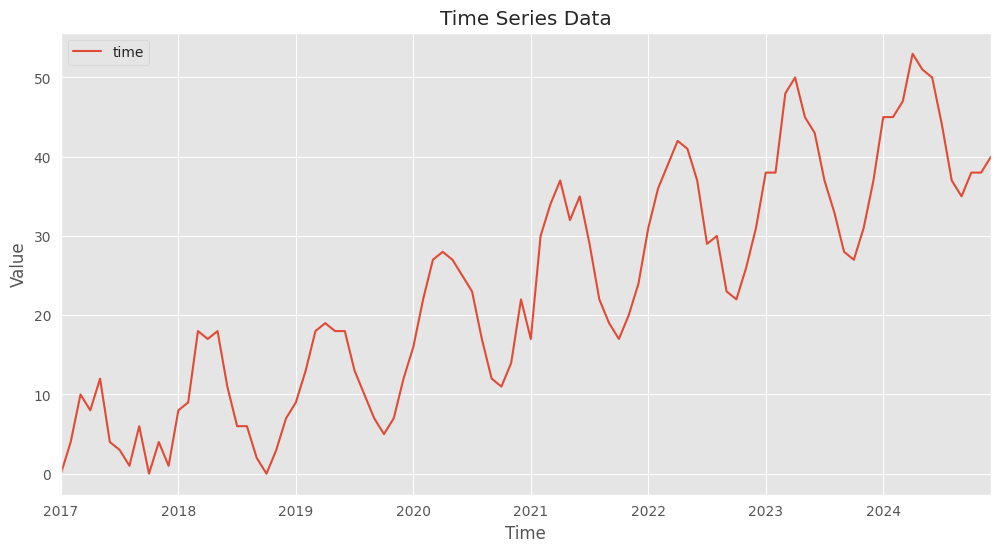

In [62]:
# View Data
data.plot(figsize=(12, 6))
plt.title('Time Series Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

## Time Series Decomposition

In [64]:
# STL Fit
stl = STL(data, period=12)
decomposition = stl.fit()

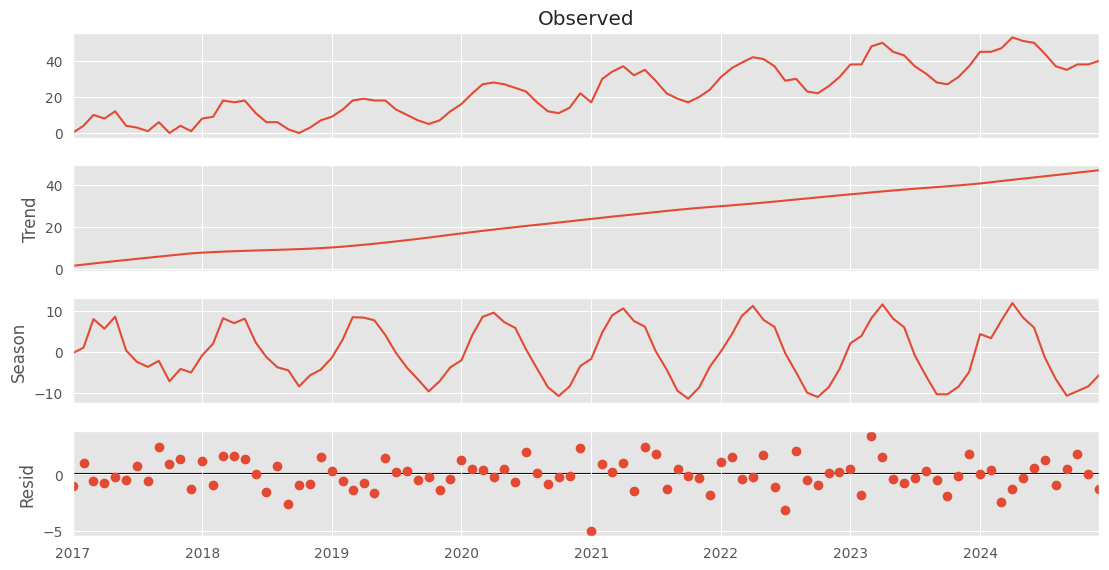

In [65]:
# Decomposition Plot
decomposition.plot().figure.set_size_inches(12, 6)
plt.show()

In [91]:
# ADF

result = adfuller(data)
print('Original Data')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

print('\n----\n')

result = adfuller(data.diff().dropna())
print('Differenced Data')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

Original Data
ADF Statistic: 0.578624
p-value: 0.987077

----

Differenced Data
ADF Statistic: -7.778513
p-value: 0.000000


In [136]:
from scipy.stats import kruskal
from scipy.stats import friedmanchisquare

# Group data by month
monthly_data = [data['time'][data.index.month == month].dropna().values for month in range(1, 13)]

# Perform Kruskal-Wallis test
statistic, p_value = kruskal(*monthly_data)

print(f'Kruskal-Wallis Test Statistic: {statistic}')
print(f'P-value: {p_value}')

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis - there is a statistically significant difference in the distributions across months (evidence of seasonality).")
else:
    print("Fail to reject the null hypothesis - there is no statistically significant difference in the distributions across months (no strong evidence of seasonality).")

Kruskal-Wallis Test Statistic: 12.940190498493106
P-value: 0.297252510416662
Fail to reject the null hypothesis - there is no statistically significant difference in the distributions across months (no strong evidence of seasonality).


In [113]:
# Friedman Test
statistic, p_value = friedmanchisquare(*monthly_data)
print(f'Statistic: {statistic}, P-Value: {p_value}')

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis - there is a statistically significant difference in the distributions across months (evidence of seasonality).")
else:
    print("Fail to reject the null hypothesis - there is no statistically significant difference in the distributions across months (no strong evidence of seasonality).")

Statistic: 75.03883495145635, P-Value: 1.3323811579253673e-11
Reject the null hypothesis - there is a statistically significant difference in the distributions across months (evidence of seasonality).


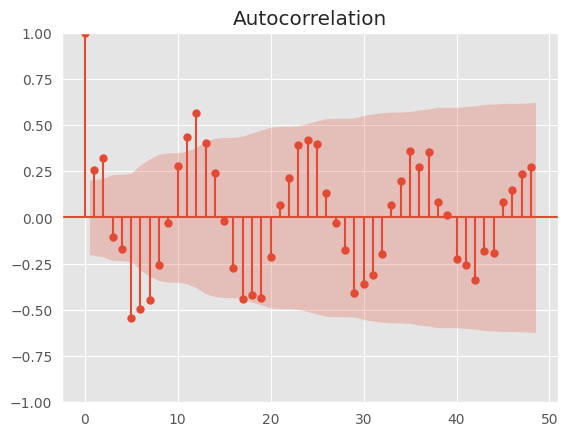

In [85]:
# ACF
plot_acf(data.diff().dropna(), lags=48)
plt.show()

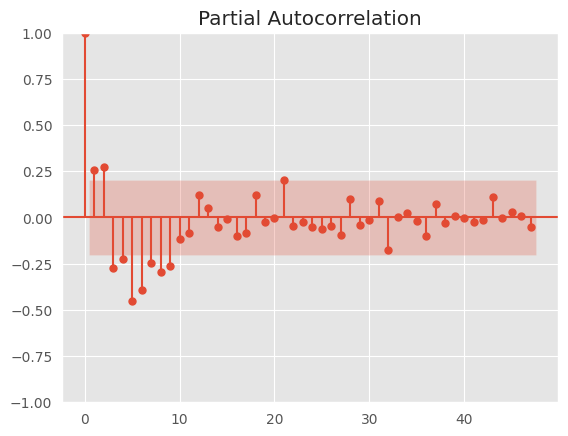

In [92]:
# PACF
plot_pacf(data.diff().dropna(), lags=47)
plt.show()

## Simple Exponential Smoothing Model

Let's fit this time series into a SES and see the results.

In [66]:
from statsmodels.tsa.api import SimpleExpSmoothing

In [67]:
# Fit the model
ses = SimpleExpSmoothing(data, initialization_method='estimated')
ses_fit = ses.fit()

# Forecast next 12 periods
forecast = ses_fit.forecast(12)

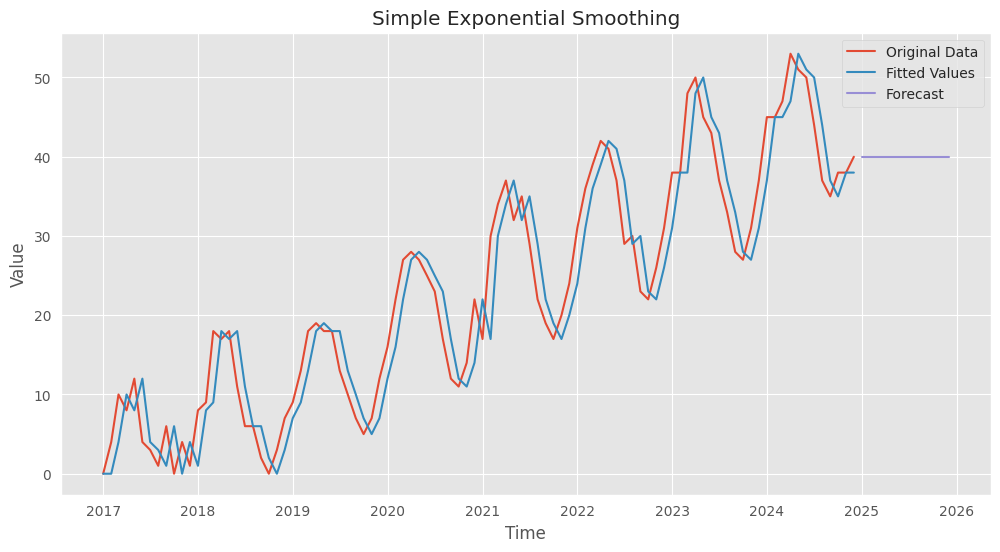

In [68]:
# Plot results
plt.figure(figsize=(12, 6))
plt.plot(data, label='Original Data')
plt.plot(ses_fit.fittedvalues, label='Fitted Values')
plt.plot(forecast, label='Forecast')
plt.legend()
plt.title('Simple Exponential Smoothing')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

In [130]:
from sklearn.metrics import root_mean_squared_error

# RMSE
print(f'RMSE: {root_mean_squared_error(data, ses_fit.fittedvalues)}')

RMSE: 4.550640998126667


## Holt-Winters Exponential Smoothing

In [103]:
# Fit the model
hw = ExponentialSmoothing(data,
                          trend='add', seasonal='add',
                          seasonal_periods=12,
                          initialization_method='estimated')
hw_fit = hw.fit()

# Forecast next 12 periods
forecast = hw_fit.forecast(12)

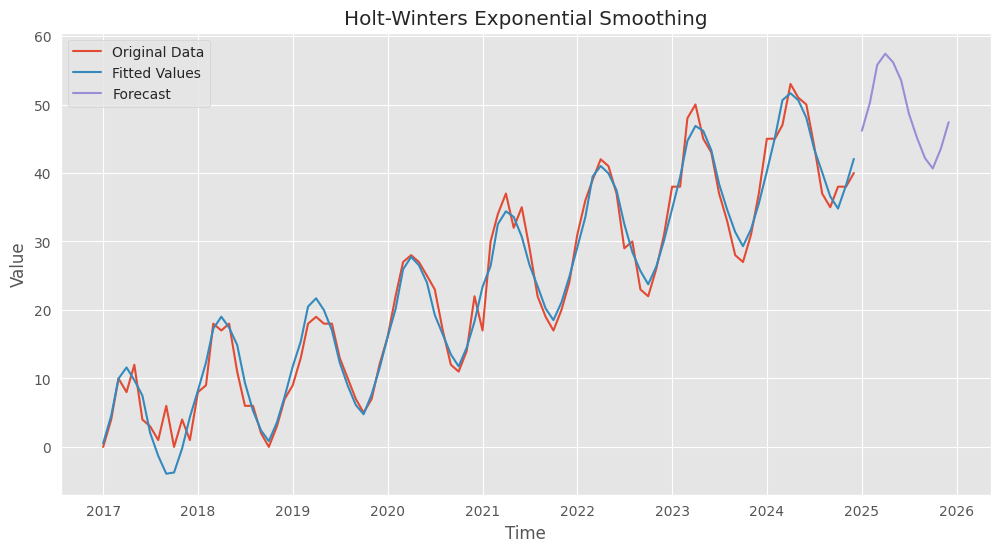

In [105]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(data, label='Original Data')
plt.plot(hw_fit.fittedvalues, label='Fitted Values')
plt.plot(forecast, label='Forecast')
plt.legend()
plt.title('Holt-Winters Exponential Smoothing')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

In [129]:
# RMSE
print(f'RMSE: {root_mean_squared_error(data, hw_fit.fittedvalues)}')

RMSE: 2.410873404862443


In [131]:
(4.55-2.41)/4.55

0.47032967032967027